In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mnist_utils
import random
import relu_utils as alg
import spiking_relu as sr
import copy
import scipy

In [6]:
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.1,
                   'tau_m': 20.0,
                   'tau_refrac': 1.,
                   'tau_syn_E': 5.0,
                   'tau_syn_I': 5.0,
                   'v_reset': -65.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

#Figure 1: Physics measurement of noisy current
Implement sigert in python

In [12]:
mi = 0.8
si = 0.2
C = 1. #cell_params_lif['cm']
mu = mi/C
sigma = np.sqrt(2.) * si / C
print mu, sigma

0.8 0.282842712475


In [13]:
def integrand(u):
    from scipy.special import erf
    return np.sqrt(np.pi)*np.exp(u**2)*(erf(u)+1)
def responsefunc(mu, sigma, cell_para):
    offset = 0.
    from scipy.integrate import quad
    vr = cell_para['v_rest']/1000.
    vth = cell_para['v_thresh']/1000. #- vr + offset
    #vr = offset
    tau = cell_para['tau_m']/1000.
    tau_r = cell_para['tau_refrac']/1000.
#     vr=9.9/1000.
#     vth=20./1000.
#     tau=26.3/1000.
#     tau_r=9.4/1000.
    vr_hat = (vr - mu*tau)/(sigma*np.sqrt(tau))
    vth_hat = (vth - mu*tau)/(sigma*np.sqrt(tau))
    integ = quad(integrand, vr_hat, vth_hat)[0]
    #print vr_hat, vth_hat, integ
    return 1./(tau_r + tau*integ)

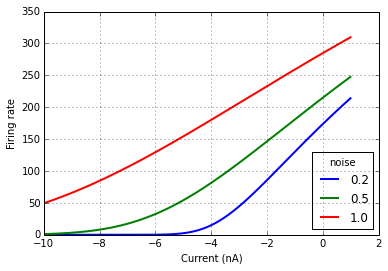

In [214]:
x = np.arange(-10,1,0.01)
sigma = np.array([0.2, 0.5, 1.])
y = np.zeros((x.size,sigma.size))
for j in range(sigma.size):
    for i in range(x.size):
        y[i][j] = responsefunc(x[i], sigma[j], cell_params_lif)
curve = plt.plot(x,y,linewidth=2)
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.legend(curve, sigma, title='noise', loc='lower right') #, shadow=True loc='upper left'
plt.savefig('pic/1.pdf')

#Figure 2: noisy_current against firing rate

In [15]:
def noise_current(current, stdnoise, cell_params_lif, trial):
    import pyNN.nest as p
    runtime = 10000.
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    poplist = []
    ratelist = np.zeros(trial)
    for i in range(trial):
        pop = p.Population(1, p.IF_curr_exp, cell_params_lif)
        noise = p.NoisyCurrentSource(mean=current, stdev=stdnoise, start=0, stop=runtime, dt=1.0,rng=p.NativeRNG(seed=i))
        noise.inject_into(pop)
        pop.record()
        poplist.append(pop)
    p.run(runtime)
    for i in range(trial):
        spikes = poplist[i].getSpikes(compatible_output=True)
        ratelist[i] = len(spikes)*1000./runtime
    p.end()
    return ratelist.mean(), ratelist.max(), ratelist.min()

In [16]:
trial = 5
stdnoise = np.array([0, 0.2, 0.5, 1., 2.])
current = np.arange(-0.5,1,0.1)

x_num = current.size
noise_num = stdnoise.size
rate_mean = np.zeros((x_num, stdnoise.size))
rate_max = np.zeros((x_num, stdnoise.size))
rate_min = np.zeros((x_num, stdnoise.size))
for j in range(noise_num):
    for i in range(x_num):
        rate_mean[i,j], rate_max[i,j], rate_min[i,j] = noise_current(current[i], stdnoise[j], cell_params_lif,trial)
#plt.plot(current, rate_mean, 'green')
#plt.fill_between(current, rate_min, rate_max, facecolor='green', alpha=0.5, interpolate=True)

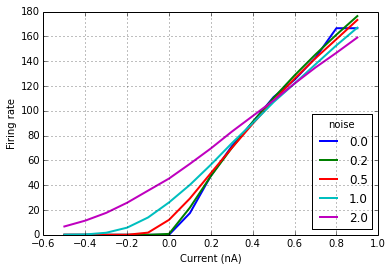

In [215]:
curve = plt.plot(current, rate_mean, linewidth=2)
for i in range(len(curve)):
    c = plt.getp(curve[i],'color')
    #plt.fill_between(current, rate_min[:,i], rate_max[:,i], facecolor=c, alpha=0.5, interpolate=True)
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.legend(curve, stdnoise, title='noise', loc='lower right') #, shadow=True loc='upper left'
plt.savefig('pic/2.pdf')

#Figure 3: noisy current generated by Poisson spikes vs. firing rate
y_noise = np.sqrt(signal.convolve2d(abs(xi),np.transpose(w**2.),mode='valid'))

In [2]:
def gen_spikesource(num, dur, rate):
    from mnist_utils import poisson_generator
    spike_source_data = [[] for i in range(num)]
    for i in range(num):
        t_start = 0
        t_stop = dur
        spikes = poisson_generator(rate, t_start, t_stop)
        if spikes != []:
            spike_source_data[i].extend(spikes)
            
    return spike_source_data

In [9]:
def noise_poisson(mu, sigma, trial):
    import pyNN.nest as p
    runtime = 10000.
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    
    num = 25
    w = 0.1
    rate_sub = mu/w
    rate_sum = sigma/w**2
    
    rate1 = (rate_sub + rate_sum)/2.
    rate2 = (rate_sum - rate1)
    rate1 = rate1 * 1000./cell_params_lif['tau_syn_E']/float(num)
    rate2 = rate2 * 1000./cell_params_lif['tau_syn_I']/float(num)
    #print mu, sigma, rate_sub, rate_sum, rate1, rate2
    poplist = []
    ratelist = np.zeros(trial)
    
    np.random.seed(0)
    for i in range(trial):
        spike_source_data1 = gen_spikesource(num, runtime, rate1)
        spike_source_data2 = gen_spikesource(num, runtime, rate2)
        pop = p.Population(1, p.IF_curr_exp, cell_params_lif)
        noise1 = p.Population(num,  p.SpikeSourceArray, {'spike_times' : []})
        noise2 = p.Population(num,  p.SpikeSourceArray, {'spike_times' : []})
        for j in range(num):
            noise1[j].spike_times = spike_source_data1[j]
            noise2[j].spike_times = spike_source_data2[j]
            
        ee_connector = p.AllToAllConnector(weights=w)
        in_connector = p.AllToAllConnector(weights=-w)
        p.Projection(noise1, pop, ee_connector, target='excitatory')
        p.Projection(noise2, pop, in_connector, target='inhibitory')
        pop.record()
        poplist.append(pop)
    p.run(runtime)
    for i in range(trial):
        spikes = poplist[i].getSpikes(compatible_output=True)
        ratelist[i] = len(spikes)*1000./runtime
    p.end()
    return ratelist.mean(), ratelist.max(), ratelist.min()

In [10]:
trial = 1
stdnoise = np.array([0, 0.2, 0.5, 1., 2.])
current = np.arange(-0.5,1,0.1)

x_num = current.size
noise_num = stdnoise.size
rate_mean2 = np.zeros((x_num, stdnoise.size))
rate_max2 = np.zeros((x_num, stdnoise.size))
rate_min2 = np.zeros((x_num, stdnoise.size))
for j in range(noise_num):
    for i in range(x_num):
        rate_mean2[i,j], rate_max2[i,j], rate_min2[i,j] = noise_poisson(current[i], stdnoise[j],trial)

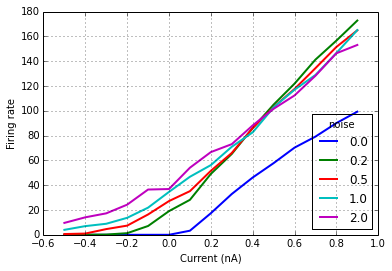

In [216]:
curve = plt.plot(current, rate_mean2, linewidth=2)
for i in range(len(curve)):
    c = plt.getp(curve[i],'color')
    #plt.fill_between(current, rate_min2[:,i], rate_max2[:,i], facecolor=c, alpha=0.5, interpolate=True)
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.legend(curve, stdnoise, title='noise', loc='lower right') #, shadow=True loc='upper left'
plt.savefig('pic/3.pdf')

#Figure 4: noisy_softplus vs. all the above with scaled output

/opt/ipython/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from IPython.kernel.zmq import kernelapp as app


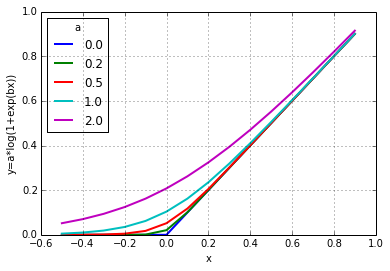

In [217]:
a = stdnoise*0.15
b = np.ones(a.size)/a
x = np.arange(-5, 10, 1.)*0.1
y = np.zeros((x.size, a.size))
for i in range(a.size):
    if a[i]>0:
        y[:,i] = a[i] * np.log(1+np.exp(b[i]*x))
    else:
        y[x>0,i] = x[x>0]
curve = plt.plot(x,y, linewidth=2)
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y=a*log(1+exp(bx))')
plt.legend(curve, stdnoise, title='a', loc='upper left') 
plt.savefig('pic/4.pdf')

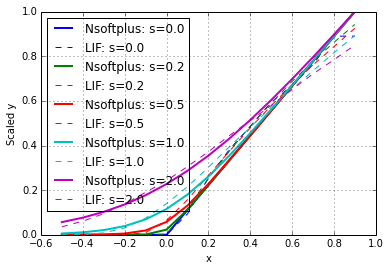

In [219]:
for i in range(stdnoise.size):
    tmp = plt.plot(x,y[:,i]/y[14,i], linewidth=2, label='Nsoftplus: s=%.1f'%stdnoise[i])
    c = plt.getp(tmp[0],'color')
    plt.plot(current, rate_mean[:,i]/rate_mean[14,0]*0.89, color=c, linestyle='dashed',linewidth=1,  label='LIF: s=%.1f'%stdnoise[i])
plt.grid('on')
plt.xlabel('x')
plt.ylabel('Scaled y')
plt.legend(loc='upper left') 
#plt.xlim((-0.5,0.5))
#plt.ylim((0,1))
#plt.legend(curve2, stdnoise, title='noise', loc='lower right') #, shadow=True loc='upper left'
plt.savefig('pic/4-2.pdf')

#Figure 5: noisy_softplus in 3D

/opt/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


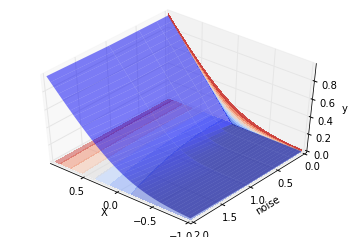

In [220]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.arange(-1, 1, 0.05)
y = stdnoise
X, Y = np.meshgrid(x, y)
a = Y*0.16
b = np.ones(a.shape)/a
Z = X.copy()
Z[Z<0] = 0
Z[a>0] = a[a>0] * np.log(1+np.exp(b[a>0]*X[a>0]))
surf = ax.plot_surface(X, Y, Z,  rstride = 1, cstride =1, alpha=0.5, linewidth=0)
cset = ax.contourf(X, Y, Z, zdir='z', alpha=0.5, offset=0, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, Z, zdir='x', alpha=0.5,offset=-10, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', alpha=0.9,offset=0., cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('noise')
ax.set_zlabel('y')
ax.view_init(azim = 130,elev = 45)
plt.savefig('pic/5.pdf')

#Figure 6: real application on 1-layer conv net

In [52]:
import cnn_utils as cnnu
w_cnn, l_cnn = cnnu.readmat('scale5.mat')
test_x, test_y = mnist_utils.get_test_data()
test_x /= 255.
dur_test = 1000
silence = 50

max_F = 140.
max_sum = 5.

In [53]:
offset = 0
num_test = 10
test = test_x[offset:(offset+num_test), :]
import pyNN.nest as p
import scnn_sim as ss
p.setup(timestep=1.0, min_delay=1.0, max_delay=3.0)
L = l_cnn

random.seed(0)
input_size = L[0][1]
pops_list = []

pops_list.append(ss.init_inputlayer(input_size, test[:num_test, :] * 30., 0, dur_test, silence)) #max_F/max_sum
for l in range(5):
    pops_list.append(ss.construct_layer(pops_list[l], L[l+1][0], L[l+1][1], w_cnn[l], cell_params_lif))

k_index = 0
observe = pops_list[1][k_index] #[1][1] #[5][0]
inpop = pops_list[0][0]
result = pops_list[5][0]

observe.record()
inpop.record()
result.record()

p.run((dur_test+silence)*num_test)
spikes = observe.getSpikes(compatible_output=True)
spikein = inpop.getSpikes(compatible_output=True)
spike_result = result.getSpikes(compatible_output=True)
p.end()

1 6
6 6
6 12
12 12
10


In [232]:
def plot_digit(img_raw, size=28, crange=(0.0, 40.), filen=''):
    #img_raw = np.uint8(img_raw)
    plt.figure(figsize=(5,5))
    im = plt.imshow(np.reshape(img_raw,(size,size)), cmap=cm.gray_r,interpolation='none', clim=crange)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',
        labelleft='off')   
    plt.savefig(filen)
    plt.show()

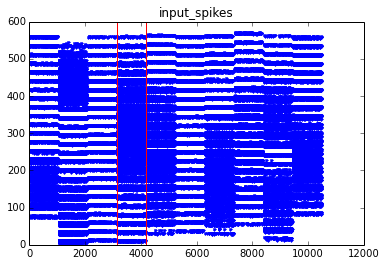

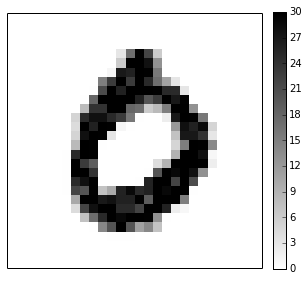

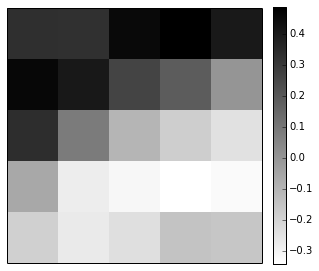

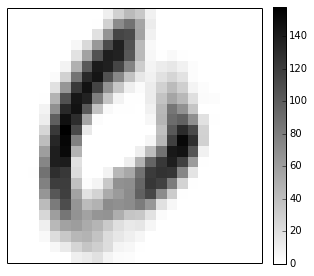

In [235]:
spike_count = ss.count_spikes(spikes, 24*24, num_test, dur_test, silence)
inspike_count = ss.count_spikes(spikein, 784, num_test, dur_test, silence)
spike_result_count = ss.count_spikes(spike_result, 10, num_test, dur_test, silence)

plt.plot([i[1] for i in spikes], [i[0] for i in spikes], ".", )
plt.title('input_spikes')
plt.plot([3150, 3150], [0, 600], 'r')
plt.plot([4200, 4200], [0, 600], 'r')
plt.savefig('pic/6-1.png')

k_digit = 3
plot_digit(inspike_count[:,k_digit], 28, crange=(0,30), filen='pic/6-2.pdf')
#plt.savefig()
plot_digit(w_cnn[0][0][k_index], 5, crange=(w_cnn[0][0][k_index].min(), w_cnn[0][0][k_index].max()), filen='pic/6-3.pdf')
# plt.savefig()
plot_digit(spike_count[:,k_digit], 24, crange=(min(spike_count[:,k_digit]), max(spike_count[:,k_digit])), filen='pic/6-4.pdf')
# plt.savefig('pic/6-4.pdf')


In [159]:
def conv2d_noise(x, w, mode='c'):
    from scipy import signal
    if len(x.shape)== 2:
        input_size = np.sqrt(x.shape[1])
        for i in range(x.shape[0]):
            #xi = np.reshape(x[i],(input_size, input_size),order='F')
            xi = np.reshape(x[i],(input_size, input_size))
            y = signal.convolve2d(xi,np.transpose(w),mode='valid')
            y_noise = np.sqrt(signal.convolve2d(abs(xi),np.transpose(w**2.),mode='valid'))
            print np.max(y_noise), np.max(y)
            y = np.nan_to_num(y)
            if mode=='s':
                w_size = w.shape[0]
                y = y[0::w_size, 0::w_size]
            #y = np.reshape(y, (1, y.shape[0]*y.shape[0]),order='F')
            #y = relu(y)
            z = softplus_noise(y, y_noise)
            z = np.reshape(z, (1, z.shape[0]*z.shape[0]))
            y = np.reshape(y, (1, y.shape[0]*y.shape[0]))
            y_noise = np.reshape(y_noise, (1, y_noise.shape[0]*y_noise.shape[0]))
            if i==0:
                y_list = y
                z_list = z
                yn_list = y_noise
            else:
                y_list = np.append(y_list, y, axis=0)
                z_list = np.append(z_list, z, axis=0)
                yn_list = np.append(yn_list, y_noise, axis=0)
        return z_list, y_list, yn_list
    else:
        print 'x has to be an array of'
        return -1
def relu(x):
    x[x<0]=0
    return x

def softplus_noise(x, noise):
    #y = relu(x)
    y = x.copy()
    rows, cols = np.where(noise>0)
    for i in range(rows.shape[0]):
        y[rows[i]][cols[i]] = softplus(x[rows[i]][cols[i]], noise[rows[i]][cols[i]]/0.25)
    
    return y

def softplus(x, a):
    b = 1./a
    sfactor = 1.#49.66
    y = a * b * x * sfactor;
    if x<10:
        y = sfactor * a * np.log(1.+ np.exp(x*b))
    return y


0.00609465072866 0.0961782371109
0.00651002873891 0.0974331523414
0.00563252471026 0.0890164063205
0.00706214612087 0.10388789192
0.00647191404583 0.0894406411766
0.00609221793778 0.0994959218316
0.00613598317218 0.0940082960101
0.00663193982076 0.0926871853913
0.00693564091893 0.10101354276
0.00682748676876 0.0970864861364


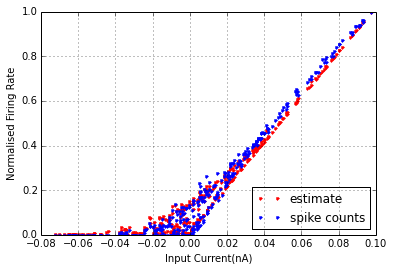

In [222]:
k_digit = 1
temp_r, orig_r, noise_r = conv2d_noise(np.transpose(inspike_count), w_cnn[0][0][k_index]/5.*0.0045) #scaled to 5
plt.plot(orig_r[k_digit], temp_r[k_digit]/temp_r[k_digit].max(),'r.', label='estimate')
plt.plot(orig_r[k_digit],spike_count[:,k_digit]/spike_count[:,k_digit].max(),'.', label='spike counts')
plt.grid('on')
plt.xlabel('Input Current(nA)')
plt.ylabel('Normalised Firing Rate')
plt.legend(loc='lower right')
# plt.savefig('2.pdf')
plt.savefig('pic/6-5.pdf')
plt.show()


#Figure 7: real application using trained weights: result


[7 2 1 0 4 1 4 9 5 9] [  1.00000000e+00   2.74878501e-43   3.87399763e-21   2.03109266e-42
   1.29958143e-24   6.47023493e-26   3.87399763e-21   2.38026641e-26
   5.24288566e-22   1.05306174e-20]


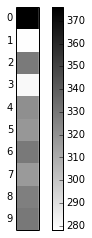

In [224]:
# plt.plot([i[1] for i in spike_result], [i[0] for i in spike_result], ".", )
# plt.title('output_spikes')
# plt.plot([3150, 3150], [0, 10], 'r')
# plt.plot([4200, 4200], [0, 10], 'r')
# plt.xlim((4000,4150))

im = plt.imshow(np.reshape(spike_result_count[:,3],(10,1)), cmap=cm.gray_r,interpolation='none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.yticks(range(10))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off')         # ticks along the top edge are off

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.savefig('pic/7.pdf')
exp_o = np.exp(spike_result_count[:, 3])
print spike_result_count.argmax(axis=0), exp_o/exp_o.sum()


#Figure 8: loss function in ANN training
sigmoid ReLU Softplus Noisy_softplus

In [200]:
import scipy.io as sio
frl = sio.loadmat('rl.mat')

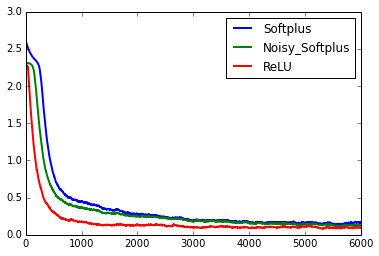

In [229]:
plt.clf()
rl = frl['a']
cureve = plt.plot(range(rl.shape[1]), np.transpose(rl), linewidth='2')
plt.legend(curve, ['Softplus', 'Noisy_Softplus', 'ReLU'],  loc='upper right') #, shadow=True loc='upper left'
plt.savefig('pic/8.pdf')